# Laboratorio 2 - Informe

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

## 1. Objetivos
El objetivo de este laboratorio es:
- Implementar el algoritmo Naive Bayes
- Aplicar herramientas de metodología
- Analizar los resultados obtenidos.

## 2. Diseño
### 2.1 Algoritmo

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate
from IPython.display import display

DATASET_FILE = "./lab1_dataset.csv"
dataset = pd.read_csv(DATASET_FILE, sep=",")
target = 'cid'
continuous_features = [
    'time',
    'age', 
    'wtkg', 
    'preanti', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
features = [
    'time', 
    'trt', 
    'age', 
    'wtkg', 
    'hemo', 
    'homo', 
    'drugs', 
    'karnof',
    'oprior', 
    'z30', 
    'zprior', 
    'preanti', 
    'race', 
    'gender', 
    'str2', 
    'strat',
    'symptom', 
    'treat', 
    'offtrt', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
dataset = dataset.drop(['pidnum'], axis=1)
print(dataset[target].value_counts())

cid
0    1618
1     521
Name: count, dtype: int64


### Implementación de Naive-Bayes

In [2]:
def naive_bayes(dataset, target, features, instance, m):
    dataset_size = dataset.shape[0]
    prob_1 = dataset[target].value_counts()[1]/dataset_size
    prob_0 = dataset[target].value_counts()[0]/dataset_size
    
    product_1 = prob_1
    product_0 = prob_0
    
    for feature in features:
        examples = dataset.loc[dataset[feature] == instance[feature]][target].value_counts()
        
        # if no instances with a specific target value is found, the get method will return 0
        count_1 = examples.get(1, default=0)
        count_0 = examples.get(0, default=0)
        
        feature_range = len(dataset[feature].value_counts())
        
        numerator_1 = count_1 + (m / feature_range)
        numerator_0 = count_0 + (m / feature_range)

        # product of sequence
        product_1 *= ( numerator_1 / (dataset[target].value_counts()[1] + m) )
        product_0 *= ( numerator_0 / (dataset[target].value_counts()[0] + m) )
        
    return (product_0/(product_0 + product_1), product_1/(product_0 + product_1))

Explicar implementación de arriba, explicitando que no retorna una clasificación, sino probabilidades de que de una clase o la otra

### Implementación de Naive-Bayes logarítmico

In [3]:
def naive_bayes_log(dataset, target, features, instance, m):
    dataset_size = dataset.shape[0]
    prob_1 = dataset[target].value_counts()[1]/dataset_size
    prob_0 = dataset[target].value_counts()[0]/dataset_size
    
    sum_1 = np.log(prob_1)
    sum_0 = np.log(prob_0)
    
    for feature in features:
        examples = dataset.loc[dataset[feature] == instance[feature]][target].value_counts()
        
        # if no instances with a specific target value is found, the get method will return 0
        count_1 = examples.get(1, default=0)
        count_0 = examples.get(0, default=0)
        
        feature_range = len(dataset[feature].value_counts())
        
        numerator_1 = count_1 + (m / feature_range)
        numerator_0 = count_0 + (m / feature_range)

        # sum of sequence
        sum_1 += np.log( numerator_1 / (dataset[target].value_counts()[1] + m) )
        sum_0 += np.log( numerator_0 / (dataset[target].value_counts()[0] + m) )
        
    return (np.exp(sum_0)/(np.exp(sum_0) + np.exp(sum_1)), np.exp(sum_1)/(np.exp(sum_0) + np.exp(sum_1)))

In [4]:
class CustomNaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, features, m):
        self.features = features
        self.m = m

    def fit(self, X_train, y_train):
        self.classes_ = np.unique(y_train)
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.X_train[target] = y_train
        return self

    def predict(self, X_test):
        y_pred = []
        for i in range(0, X_test.shape[0]):
            instance = X_test.iloc[i]
            prob_0, prob_1 = naive_bayes(self.X_train, target, self.features, instance, self.m)
            if (prob_0 > prob_1):
                y_pred.append(0)
            else:
                y_pred.append(1)
        return np.array(y_pred)
    
    
    def __sklearn_clone__(self):
        return self

Por qué determinamos esta clase (representación interna de implementación de cross validation de scikit)


### 2.3 Evaluación

Explicar métricas de evaluación que vamos a usar (accuracy, recall, precision, f1_score) y por qué usamos average weighted de cada métrica (dataset desbalanceado).

## 3. Experimentación

### 3.1 Evaluación del hiperparametro m

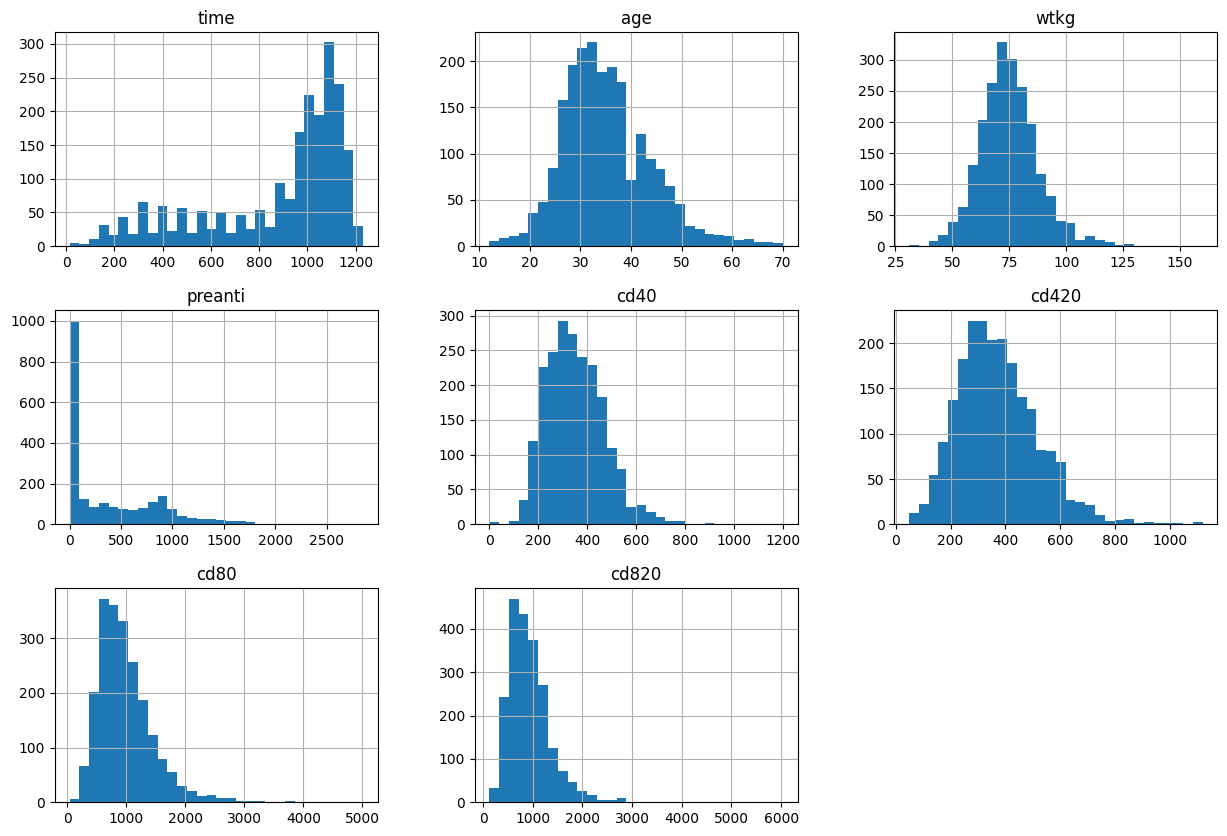

In [5]:
dataset[continuous_features].hist(bins=30, figsize=(15, 10))
plt.show()

In [6]:

# Initialize KBinsDiscretizer for continuous features
kbins = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')

# Discretize continuous features
dataset[continuous_features] = kbins.fit_transform(dataset[continuous_features])

# Prepare X and y
X = dataset.drop(target, axis=1)
y = dataset[target]

# List of m values
m_values = [1, 10, 100, 1000]

results = pd.DataFrame(columns=['m', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Iterate over m values
for m in m_values:
    model = CustomNaiveBayes(features, m)
    scores = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted','f1_weighted'] )
    results.loc[results.shape[0]] = [m, scores['test_accuracy'].mean(), scores['test_precision_weighted'].mean(), scores['test_recall_weighted'].mean(), scores['test_f1_weighted'].mean()]

def bold_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

styled_results = results.style.apply(bold_max, subset=['F1'])

display(styled_results)



,m,Accuracy,Precision,Recall,F1
0,1.000000,0.851315,0.848938,0.851315,0.849666
1,10.000000,0.852252,0.850432,0.852252,0.851069
2,100.000000,0.841971,0.836428,0.841971,0.836854
3,1000.000000,0.769518,0.782551,0.769518,0.686887


Hablar de preprocesamiento: KBins discretizer, por qué usamos kmeans para strategy\
Explicar el experimento (cross validation)\
Explicar resultados obtenidos (mejor m=10)

### 3.2 Evaluación de feature selection

,k,Accuracy,Precision,Recall,F1
0,1.000000,0.836449,0.839559,0.836449,0.837819
1,2.000000,0.827103,0.821334,0.827103,0.823152
2,3.000000,0.831776,0.828269,0.831776,0.829679
3,4.000000,0.848131,0.844169,0.848131,0.845467
4,5.000000,0.841121,0.836068,0.841121,0.837491
5,6.000000,0.848131,0.843227,0.848131,0.844383
6,7.000000,0.841121,0.834661,0.841121,0.835047
7,8.000000,0.848131,0.842582,0.848131,0.843233
8,9.000000,0.862150,0.857795,0.862150,0.858234
9,10.000000,0.850467,0.845514,0.850467,0.846501


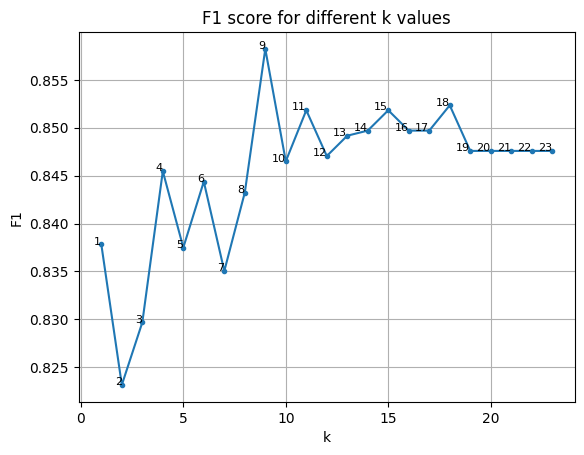

In [7]:
results = pd.DataFrame(columns=['k', 'Accuracy', 'Precision', 'Recall', 'F1'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
f1_array = []
k_array = list(range(1, 24))
for k in range(1,24):
    selector = SelectKBest(chi2, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()]
    
    train_ds = X_train[selected_features].copy()
    train_ds[target] = y_train
    
    y_pred = []
    
    for i in range(0, X_test.shape[0]):
        instance = X_test.iloc[i]
        prob_0, prob_1 = naive_bayes(train_ds, target, selected_features, instance, 10)
        if (prob_0 > prob_1):
            y_pred.append(0)
        else:
            y_pred.append(1)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_array.append(f1)
    
    results.loc[results.shape[0]] = [k, accuracy, precision, recall, f1]

styled_results = results.style.apply(bold_max, subset=['F1'])

display(styled_results)

plt.plot(k_array, f1_array, marker='.')
plt.title('F1 score for different k values')
plt.xlabel('k')
plt.ylabel('F1')
plt.grid()
for i, f1_value in enumerate(f1_array):
    plt.text(k_array[i], f1_array[i], f'{k_array[i]}', fontsize=8, ha='right')

plt.show()

En este experimento tenemos como objetivo realizar un análisis de selección de atributos utilizando el algoritmo Naive Bayes con el hiperparámetro de suavizado *m* fijo en 10, que por el experimento anterior es el *m* con mejor F1 score. Se emplea la técnica de selección de atributos `SelectKBest` junto con la estrategia **Chi-Square** (chi2) para seleccionar los mejores atributos, y para cada posible *k* cantidad de mejores atributos del rango 1 a 23 se evalúan las métricas de rendimiento como **Accuracy**, **Precision**, **Recall** y **F1 Score**.\
Respecto a la técnica de selcción de atributos usada, Chi-Square (chi2) se utiliza para evaluar la independencia de los atributos con respecto a la variable objetivo. Es particularmente efectiva cuando los atributos son categóricos, como en este caso después de la discretización de los atributos continuos mediante `KBinsDiscretizer`.\
\
Hemos obtenido que con el valor de **k=3** se obtiene la mejor F1 score de **0.860891**. Este resultado sugiere que, utilizando únicamente tres atributos, el modelo alcanzó un buen balance entre precisión y recall. Además, a medida que se incrementa **k**, se observan fluctuaciones entre 0.86 y 0.84 en la F1, teniendo mayores caidas en la score para **k=7** y **k=15**. Sin embargo, a partir de **k=19** se estabiliza, alcanzando valores consistentes cercanos a 0.856, Estas fluctuaciones indican que la adición de atributos no necesariamente mejora la calidad del modelo.\
\
Comparando estos resultados con el modelo sin selección de atributos para **m=10**, para **k=3** se obtiene un mejor valor de F1 score, con un aumento de 0.02. Esto indica no solo una mejora en el rendimiento del modelo en términos de F1, sino que también es posible obtener mejores resultados con un modelo más simplificado de menos variables, lo cual es deseable desde el punto de vista de la interpretabilidad. De la misma manera, se infiere que incluir más atributos no siempre contribuye a un mejor rendimiento. Esto podrá deberse a la redundancia o irrelevancia de algunos atributos cuando se trata de la predicción de la variable objetivo.

In [8]:
selector = SelectKBest(chi2, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

train_ds = X_train[selected_features].copy()
train_ds[target] = y_train

chi2_scores = selector.scores_

feature_scores = pd.DataFrame({
    'Feature': selected_features,
    'Chi2_Score': chi2_scores,
})

feature_scores_sorted = feature_scores.sort_values(by='Chi2_Score', ascending=False)
print(feature_scores_sorted)


    Feature  Chi2_Score
0      time  487.569962
20    cd420  211.352491
19     cd40   55.228008
11  preanti   47.215085
16  symptom   21.059162
1       trt   13.135860
21     cd80   10.376097
15    strat    9.025053
9       z30    8.650495
17    treat    8.618287
7    karnof    8.289357
18   offtrt    8.086323
14     str2    7.772575
12     race    5.222743
6     drugs    4.539810
2       age    3.136260
8    oprior    1.313644
5      homo    1.201686
22    cd820    0.398725
13   gender    0.245730
3      wtkg    0.006990
4      hemo    0.002447
10   zprior    0.000000


Una vez obtenidos los resultados del experimento anterior, realizamos un análisis más detallado de la importancia de cada uno de los atributos utilizando la técnica de Chi-Square para identificar cuáles de ellos tienen mayor relevancia para la predicción de la variable objetivo.\
De acuerdo con las puntuaciones obtenidas, los resultados muestran que el atributo time es el más relevante con un valor Chi2 significativamente alto de 2285.24, seguido por cd420 (691.07) y preanti (301.84). Esto indica que estos atributos tienen una mayor influencia en la predicción de la clase objetivo. En el extremo opuesto, atributos como homo y zprior muestran puntuaciones muy bajas, lo que sugiere que tienen poca o ninguna relevancia para la predicción.\
\
Estos resultados refuerzan la idea de que no todos los atributos contribuyen de manera significativa al rendimiento del modelo, y que aplicar técnicas de selección de atributos, como SelectKBest basado en Chi-Square, puede mejorar tanto la eficiencia como la interpretabilidad del modelo al reducir la cantidad de atributos considerados en la predicción.

### 3.3 Curva de Precision-Recall


Confusion Matrix:
[[285  32]
 [ 40  71]]




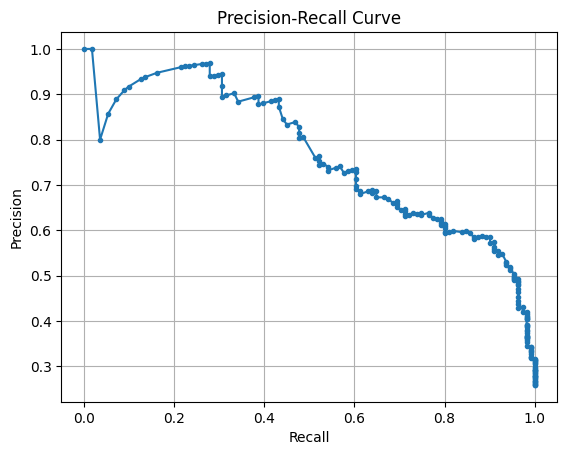

Area Under Curve: 0.7665977670866175



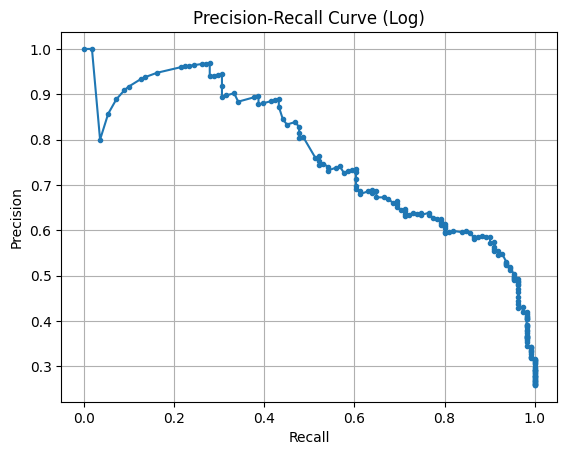

Area Under Curve (Log): 0.7665977670866175



In [9]:
selector = SelectKBest(chi2, k=3)
X_train_selected = selector.fit_transform(X_train, y_train)
selected_features = X_train.columns[selector.get_support()]

train_ds = X_train[selected_features].copy()
train_ds[target] = y_train

y_score = []
y_score_log = []
y_pred = []

for i in range(0, X_test.shape[0]):
    instance = X_test.iloc[i]
    prob_0, prob_1 = naive_bayes(train_ds, target, selected_features, instance, 10)
    prob_log_0, prob_log_1 = naive_bayes_log(train_ds, target, selected_features, instance, 10)
    y_score.append(prob_1)
    y_score_log.append(prob_log_1)
    if (prob_0 > prob_1):
        y_pred.append(0)
    else:
        y_pred.append(1)
        
precision, recall, thresholds = precision_recall_curve(y_true=y_test, y_score=y_score)
precision_log, recall_log, thresholds_log = precision_recall_curve(y_true=y_test, y_score=y_score_log)

area_under_curve = auc(recall, precision)
area_under_curve_log = auc(recall_log, precision_log)

print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n\n")

plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

print(f"Area Under Curve: {area_under_curve}\n")

plt.plot(recall_log, precision_log, marker='.')
plt.title('Precision-Recall Curve (Log)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

print(f"Area Under Curve (Log): {area_under_curve_log}\n")

Mencionar adaptación que hicimos a la implementación para bancar esto (hacer exponencial de las probs logaritimicas en la implementacion)\
No hay diferencias entre graficas, explicar por qué pasa esto (si fueran más atributos capaz habrían más problemas por la representacion interna de los datos, multiplicacion de numeros cada vez mas cicos en implementacion sin logariimos)\
(Opcional) Graficar matriz de confusion

### Comparar con lab anterior